In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
from librosa.display import specshow
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/datamatrix.csv", sep=';', index_col=0).transpose().applymap(np.log1p)
data

,100.110350,102.010985,102.032212,102.535130,109.012080,110.017963,110.522609,111.019337,111.087585,111.521389,...,945.579366,945.605541,946.580795,946.601468,946.617601,947.609497,977.587261,977.606791,978.566742,978.594623
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34.975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34.9817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34.9883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def son_optimise(mass_vector, abundance_matrix, sr=22050, duration=35, instrument="sinus"):
    try:
        assert(len(mass_vector) == len(abundance_matrix[0]))
    except:
        raise(Exception("Pas la bonne taille de données"))
    
    durationOfOneSample = duration*sr/len(abundance_matrix)
    
    time_vector = np.arange(0,duration*sr,1) / sr
    
    time_vector = time_vector.reshape((len(time_vector),1))
    mass_vector = np.transpose(mass_vector.reshape((len(mass_vector),1)))
    
    amplitude_matrix = np.array(
        [(abundance_matrix[int(i/durationOfOneSample)+1] - abundance_matrix[int(i/durationOfOneSample)]) / durationOfOneSample * (i%durationOfOneSample) + abundance_matrix[int(i/durationOfOneSample)]  
         if int(i/durationOfOneSample) < len(abundance_matrix) - 1 
         else abundance_matrix[int(i/durationOfOneSample)]
         for i in range(duration*sr)]
    )
    
    if instrument == "sinus":
        sounds = np.multiply(amplitude_matrix, np.sin(np.pi * np.matmul(time_vector, mass_vector)))
    elif instrument == "violon":
        sounds = np.multiply(amplitude_matrix, instrument_violon(np.matmul(time_vector, mass_vector)))
    else:
        raise Exception("Invalid Instrument")
    ### Fin de l'update ###
    
    audio = np.mean(sounds,axis=1)
    
    return audio / np.max(audio)

In [4]:
def def_abundance_matrix(df, spikes, nb_pics=None, pic_selection="most_abundant"):
    # NB : spikes a un rôle analogue à spike_height dans son_v3
    # La définition de sorting_values change selon le mode de sélection
    
    if pic_selection == "most_abundant":
        sorting_values = np.sum(spikes, axis=0)
    elif pic_selection == "highest_mass":
        sorting_values = df.columns[-spikes.shape[1]:]
    elif pic_selection == "lowest_mass":
        sorting_values = (-1)*df.columns[-spikes.shape[1]:]
    else:
        raise Exception("Error : acceptable values for pic_selection are \"most_abundant\", \"highest_mass\", \"lowest_mass\"")
    if nb_pics is None or nb_pics <= 0: 
        nb_pics = len(spikes)
    
    sorted_args = np.argsort(sorting_values)[::-1]
    am = spikes[:,sorted_args]
    am[:,nb_pics:] = 0
    
    return am, sorted_args

In [5]:
for mzOver200ind in range(len(data.columns)):
    if data.columns[mzOver200ind] > 200 and (len(data.columns) - mzOver200ind) % 10 == 0: break

X = data.to_numpy()[:3400,mzOver200ind:]
print(f"{X.shape = }")

X.shape = (3400, 700)


In [6]:
X_merged = np.ndarray((X.shape[0],X.shape[1]//10),dtype='float64')
for i in range(X_merged.shape[1]):
    X_merged[:,i] = np.mean(X[:,i*10:(i+1)*10],axis=1)
print(f"{X_merged.shape = }")

X_merged.shape = (3400, 70)


In [7]:
b = np.blackman(200) # M = 20 donne un résultat précis, mais si on veut entendre sur une durée significante, il faut plus long
X_smoothed = np.apply_along_axis(
    lambda m: np.convolve(m,b,'same'), 
    axis=0, arr=X_merged)

print(f"{X_smoothed.shape = }")

X_smoothed.shape = (3400, 70)


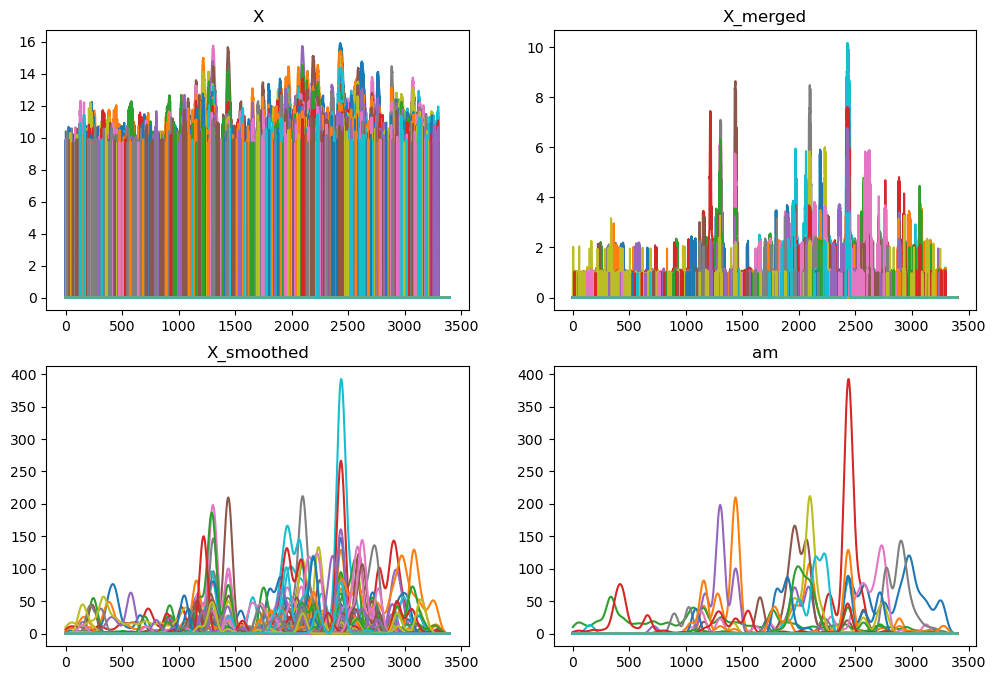

In [8]:
am, sorted_args = def_abundance_matrix(data, X_smoothed, nb_pics=14, pic_selection="most_abundant")

fig, ax = plt.subplots(2,2, figsize=(12,8))
to_plot = [X, X_merged, X_smoothed, am]
name = ['X', 'X_merged', 'X_smoothed', 'am']
for p,x,x_name in zip(np.nditer(ax, flags=["refs_ok"]),to_plot,name):
    p[()].plot(x)
    p[()].title.set_text(f'{x_name}')

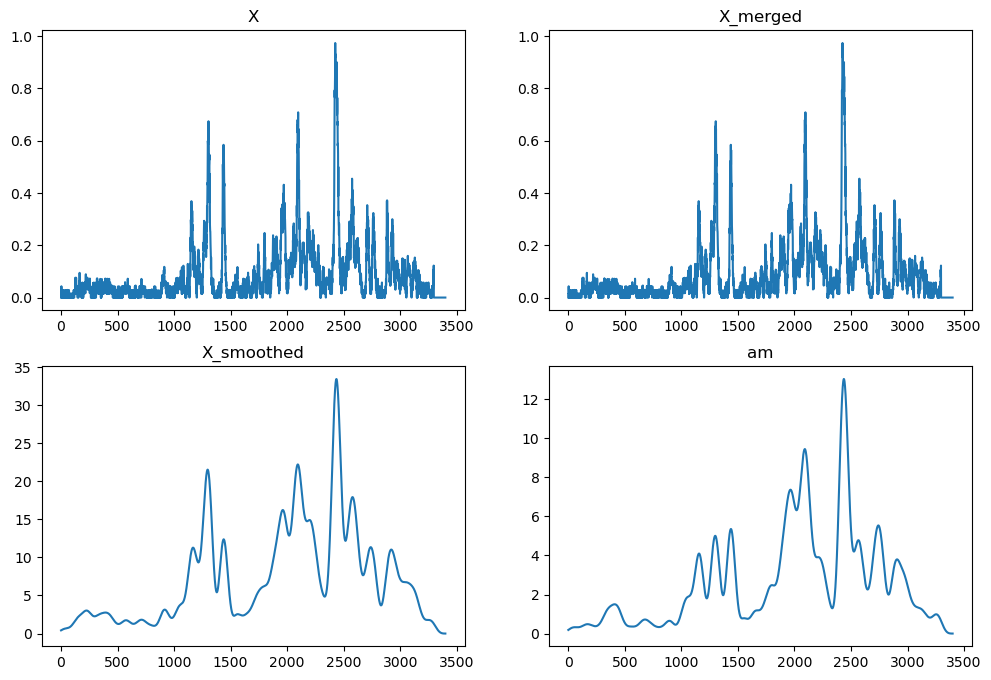

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
to_plot = [X, X_merged, X_smoothed, am]
name = ['X', 'X_merged', 'X_smoothed', 'am']
for p,x,x_name in zip(np.nditer(ax, flags=["refs_ok"]),to_plot,name):
    p[()].plot(np.mean(x,axis=1))
    p[()].title.set_text(f'{x_name}')

In [10]:
list_of_all_the_piano_notes = np.sort([
    32.70 ,65.41 ,130.81 ,261.63 ,523.25 ,1046.50 ,2093.00 ,4186.01 ,
    34.65 ,69.30 ,138.59 ,277.18 ,554.37 ,1108.73 ,2217.46 ,4434.92 ,
    36.71 ,73.42 ,146.83 ,293.66 ,587.33 ,1174.66 ,2349.32 ,4698.63 ,
    38.89 ,77.78 ,155.56 ,311.13 ,622.25 ,1244.51 ,2489.02 ,4978.03 ,
    41.20 ,82.41 ,164.81 ,329.63 ,659.25 ,1318.51 ,2637.02 ,5274.04 ,
    43.65 ,87.31 ,174.61 ,349.23 ,698.46 ,1396.91 ,2793.83 ,5587.65 ,
    46.25 ,92.50 ,185.00 ,369.99 ,739.99 ,1479.98 ,2959.96 ,5919.91 ,
    49.00 ,98.00 ,196.00 ,392.00 ,783.99 ,1567.98 ,3135.96 ,6271.93 ,
    51.91 ,103.83 ,207.65 ,415.30 ,830.61 ,1661.22 ,3322.44 ,6644.88 ,
    55.00 ,110.00 ,220.00 ,440.00 ,880.00 ,1760.00 ,3520.00 ,7040.00 ,
    58.27 ,116.54 ,233.08 ,466.16 ,932.33 ,1864.66 ,3729.31 ,7458.62 ,
    61.74 ,123.47 ,246.94 ,493.88 ,987.77 ,1975.53 ,3951.07 ,7902.13
])

list_of_harmonics = np.array([30*i for i in range(1,100)])

print(f'{list_of_all_the_piano_notes.shape = }')
print(f'{list_of_harmonics.shape = }')

list_of_all_the_piano_notes.shape = (96,)
list_of_harmonics.shape = (99,)


In [11]:
# Paramètres

sr = 11000 # sampling rate (fréquence d'échantillonage)
duration = 10
mass_vector = list_of_harmonics[sorted_args]
abundance_matrix = am

In [12]:
mass_vector

array([1560,  480,  570, 1200,  510,  900, 1140,  420,  840, 1410,  930,
        660,  600,   30, 1020,  690, 1290, 1170,  540, 1800, 1320,   60,
       1860, 1710, 1950,  870,  120,  300,  750, 1440, 2010, 1260,  180,
        960,  330,  990, 1890, 1350,  390, 1680,  240,  210,  270,  450,
         90,  150,  720, 1380, 1590, 1530,  810, 1620, 1230,  360, 1050,
       1080, 1980,  630, 1500,  780, 1830, 1110, 1920, 2070, 1650, 1470,
       2100, 1740, 2040, 1770])

In [13]:
%%time
audio = son_optimise(mass_vector, abundance_matrix, sr, duration)
display(ipd.Audio(audio, rate=sr))

CPU times: user 5.6 s, sys: 268 ms, total: 5.87 s
Wall time: 5.87 s


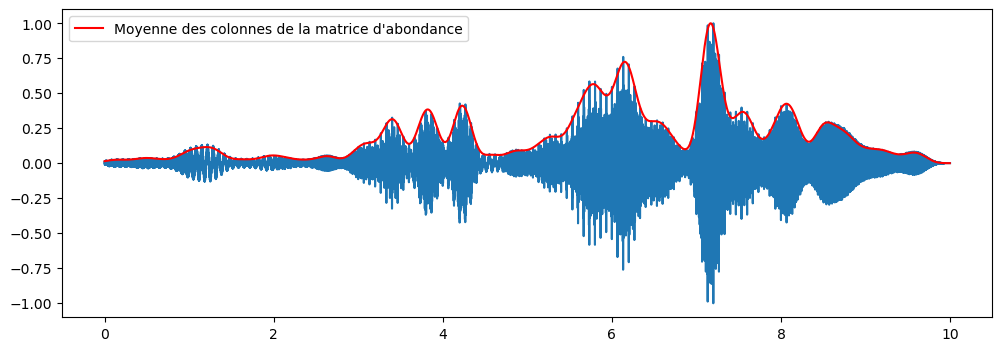

In [14]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,duration,1/sr),audio);
plt.plot(np.arange(0,duration,duration/len(am)),np.mean(am,axis=1)/np.max(np.mean(am,axis=1)),color='red',label="Moyenne des colonnes de la matrice d'abondance")
plt.legend();

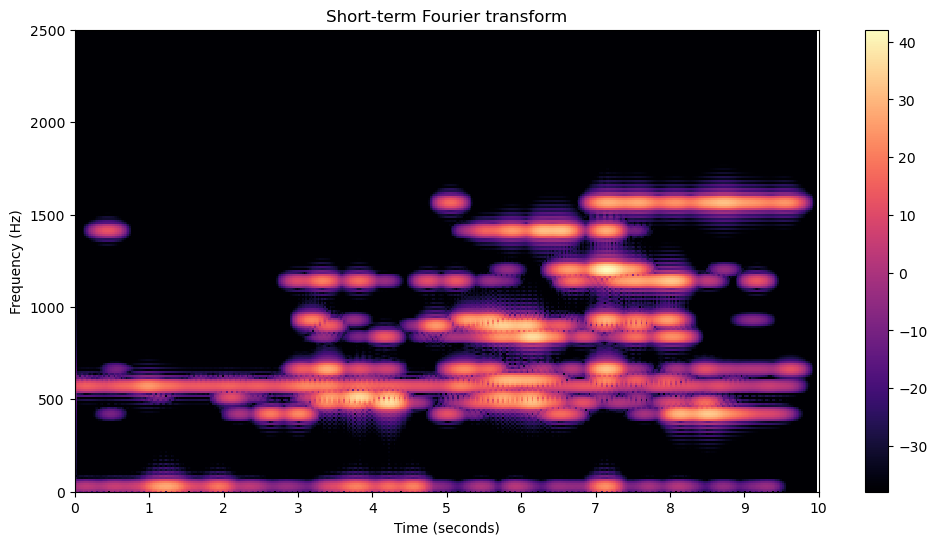

In [15]:
# Affichage du spectrogramme

plt.figure(figsize=(12, 6))

y_stft = librosa.stft(np.array(audio), win_length=1024)
y_spectrogram = librosa.amplitude_to_db(np.abs(y_stft))
specshow(y_spectrogram, cmap="magma", x_axis="time", y_axis="hz")
plt.title("Short-term Fourier transform")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.xlim(0, duration)
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 2500);